In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim
import copy
from PIL import Image
import math
from math import sqrt
from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.image as mpimg


%matplotlib inline

In [9]:
from kushwant_rakshit2_shalkuri_final_project_model_weights.ESPCNN import ESPCNN
from kushwant_rakshit2_shalkuri_final_project_model_weights.FSRCNN import FSRCNN
from kushwant_rakshit2_shalkuri_final_project_model_weights.SRCNN import SRCNN
from kushwant_rakshit2_shalkuri_final_project_model_weights.ESRGAN import ESRGAN
from kushwant_rakshit2_shalkuri_final_project_model_weights.DBPN import DBPN
from kushwant_rakshit2_shalkuri_final_project_model_weights.SRGAN import SRGAN

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# for loading dataset
class SuperResolutionDataset(Dataset):
    def __init__(self, low_res_image_dir, high_res_image_dir, csv_file=None, image_data=None, transform=None):
        if image_data is not None:
            self.image_data = image_data
        elif csv_file is not None:
            self.image_data = pd.read_csv(csv_file)
        self.transform = transform
        self.gan_transform = transforms.Compose([transforms.Resize((96, 96))])
        self.fixed_size = (800, 1200)
        self.csv_file = csv_file
        self.high_res_image_dir = high_res_image_dir
        self.low_res_image_dir = low_res_image_dir

        if len(self.image_data) == 0:
            raise ValueError(f"No image files found in CSV file: {csv_file}")
        
        print(f"Found {len(self.image_data)} image pairs.")

    def __len__(self):
        return len(self.image_data)
    
    def train_val_test_split(self, r1, r2, r3):
        assert r1 + r2 + r3 == 1, "Ratios must sum to 1"
        
        train_data, temp_data = train_test_split(self.image_data, test_size=(1 - r1))
        val_data, test_data = train_test_split(temp_data, test_size=(r3 / (r2 + r3)))
        
        train_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=train_data.reset_index(drop=True),
                                               transform=self.transform)
        
        val_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=val_data.reset_index(drop=True),
                                               transform=self.transform)
        
        test_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=test_data.reset_index(drop=True),
                                               transform=self.transform)
        
        return train_dataset, val_dataset, test_dataset

    def __getitem__(self, index):
        # get image names in folders using index
        lr_image_path = self.image_data.iloc[index, 0]
        hr_image_path = self.image_data.iloc[index, 1]

        # add image path and convert it to RGB
        lr_img = Image.open(self.low_res_image_dir+lr_image_path).convert('RGB')
        hr_img = Image.open(self.high_res_image_dir+hr_image_path).convert('RGB')

        # resixe low res image to high res image size
        lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)

        #apply transform for both images
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)
        return lr_img, hr_img
    
    def get_test_images(self, num_images=10):
        if len(self.image_data) < num_images:
            raise ValueError(f"The dataset has only {len(self.image_data)} images, which is less than the requested {num_images} images.")

        # Randomly select indices for the test images
        indices = np.random.choice(len(self.image_data), num_images, replace=False)

        test_images = []
        gan_test_images = []
        for index in indices:
            lr_img, hr_img = self.__getitem__(index)
            test_images.append((lr_img, hr_img))
        for index in indices:
            lr_img, hr_img = self.__getitem__(index)
            if self.gan_transform:
                lr_img = self.gan_transform(hr_img)
            gan_test_images.append((lr_img, hr_img))

        return test_images, gan_test_images

In [5]:
# define resize and transform
transform = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Resize((384, 384), interpolation=Image.BICUBIC),
    transforms.ToTensor()
])

img_set_path = "image_dataset/Image Super Resolution - Unsplash/"

# load and apply transform to all images and map csv file mapping from low res to high res images
img_dataset = SuperResolutionDataset(csv_file=img_set_path+"image_data.csv",
                                     low_res_image_dir= img_set_path+"/low res/",
                                     high_res_image_dir= img_set_path+"/high res/",
                                     transform=transform)

Found 3762 image pairs.


/scratch/16372136/ipykernel_2998830/1864039461.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((384, 384), interpolation=Image.BICUBIC),
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [38]:
num_images = 10
# split the dataset to train test and validation in ratio 70:15:15
test_dataset, gan_test_dataset = img_dataset.get_test_images(num_images=num_images)

/scratch/16372136/ipykernel_2998830/3207824639.py:56: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)


In [39]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
gan_test_loader = DataLoader(gan_test_dataset , batch_size=1, shuffle=False)

In [40]:
# Function to show lowres and high res images side by side
def show_tensorpair(tensor_pair):
    # convert to numpy for display
    lr_img = tensor_pair[0].cpu().numpy()
    hr_img = tensor_pair[1].cpu().numpy()
    print(lr_img.shape)
    print(hr_img.shape)
    # transpose the image reording the dimension from tensor to matplotlib use
    lr_img = lr_img.transpose(1,2,0)
    hr_img = hr_img.transpose(1,2,0)

    # display images using subplot
    fig, axs = plt.subplots(1, 2, figsize=(12, 20))
    axs[0].imshow(lr_img, cmap='gray')
    axs[0].set_title('Low-res Image')
    axs[0].axis('off')
    axs[1].imshow(hr_img, cmap='gray')
    axs[1].set_title('High-res Image')
    axs[1].axis('off')
    
    plt.show()

(3, 96, 96)
(3, 384, 384)


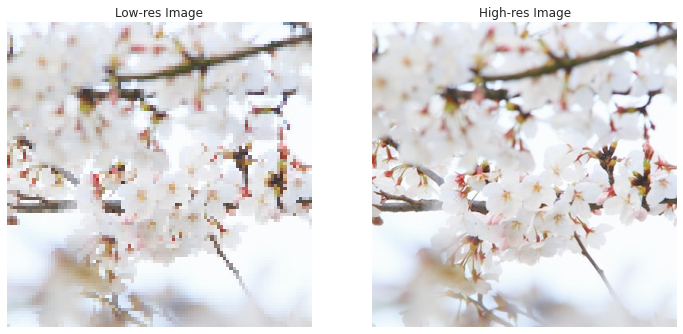

In [41]:
show_tensorpair(gan_test_dataset[0])

(3, 384, 384)
(3, 384, 384)


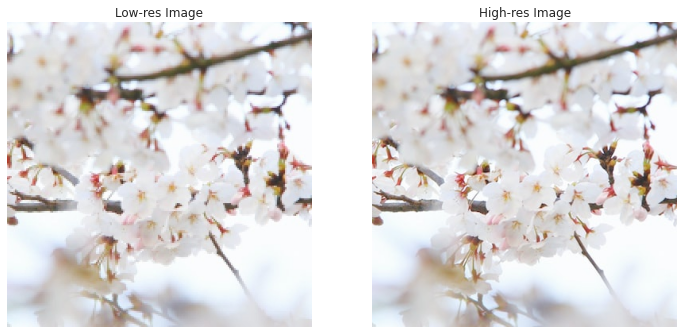

In [42]:
show_tensorpair(test_dataset[0])

In [43]:
model_weights_folder = "kushwant_rakshit2_shalkuri_final_project_model_weights"
model_info = {
    "ESPCNN": {"pth": model_weights_folder+"/kushwant_rakshit2_shalkuri_final_project_espcnn.pth","class":ESPCNN},
    "FSRCNN": {"pth": model_weights_folder+"/kushwant_rakshit2_shalkuri_final_project_fsrcnn.pth", "class":FSRCNN},
    "SRCNN": {"pth": model_weights_folder+"/kushwant_rakshit2_shalkuri_final_project_srcnn.pth", "class": SRCNN},
    "SRGAN": {"pth": model_weights_folder+"/kushwant_rakshit2_shalkuri_final_project_srgan.pth", "class": SRGAN},
    "ESRGAN": {"pth": model_weights_folder+"/kushwant_rakshit2_shalkuri_final_project_esrgan.pth", "class": ESRGAN},
    "DBPN": {"pth": model_weights_folder+"/kushwant_rakshit2_shalkuri_final_project_dbpn.pth", "class": DBPN}
}

In [44]:
psnr_vals = dict()
ssim_vals = dict()

In [45]:
def save_image(tensor, path):
    img = TF.to_pil_image(tensor.cpu().squeeze(0))
    img.save(path)

def process_and_save_images(model, model_name, data_loader, output_dir):
    
    model.eval()
    # Create directories to store the images for the model
    model_output_dir = os.path.join(output_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    psnr_vals[model_name] = []
    ssim_vals[model_name] = []

    # Iterate through the DataLoader with tqdm progress bar
    for i, (lr_img, hr_img) in enumerate(tqdm(data_loader, desc=model_name)):
        # Save low-res and high-res images
        save_image(lr_img, os.path.join(output_dir, f'low_res_images/lr_image_{i}.png'))
        save_image(hr_img, os.path.join(output_dir, f'high_res_images/hr_image_{i}.png'))
        
        # Process the image through the model and save the super-resolved image
        with torch.no_grad():
            lr_img = lr_img.to(device)
            sr_img = model(lr_img)
            psnr_vals[model_name].append(calculate_psnr(sr_img, hr_img.to(device)))
            ssim_vals[model_name].append(calculate_ssim(sr_img, hr_img.to(device)))

        save_image(sr_img.cpu(), os.path.join(model_output_dir, f'sr_image_{i}.png'))

In [46]:
# Function to calculate peak signal-to-noise ratio
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * math.log10(max_pixel / math.sqrt(mse.item()))

In [47]:
def calculate_ssim(output, target):
    """Calculates the average SSIM for a batch of images."""
    batch_size, channels, height, width = output.shape
    img_ssim_values = []

    # iterate over each image in the batch
    for i in range(batch_size):

        # average SSIM values across channels
        opimg = np.transpose(output[i].cpu().numpy(), (1, 2, 0))
        ogimg = np.transpose(target[i].cpu().numpy(), (1, 2, 0))

        img_ssim_val = ssim(opimg, ogimg, channel_axis=-1, data_range=ogimg.max() - ogimg.min())
        # take mean of all channels as ssim value for the image
        img_ssim_values.append(np.mean(img_ssim_val))

    # if there are any nan values then make it 0.0
    img_ssim_values = [0.0 if np.isnan(x) else x for x in img_ssim_values]

    if np.isnan(np.mean(img_ssim_values)):
        print(img_ssim_values)

    # return avrage of all images in the batch and return it as ssim value of all images in the batch
    return np.mean(img_ssim_values)

In [54]:
def display_images_grid(index, low_res_dir, high_res_dir, output_dir, model_names):
    sns.set(style="whitegrid", context="notebook")

    # get outputted images from low res and high res directory
    out_images = []
    out_images.append(os.path.join(low_res_dir, f'lr_image_{index}.png'))
    out_images.append(os.path.join(high_res_dir, f'hr_image_{index}.png'))

    # get the output images generated by eahc model
    for model_name in model_names:
        model_output_dir = os.path.join(output_dir, model_name)
        model_image = os.path.join(model_output_dir, f'sr_image_{index}.png')
        out_images.append(model_image)
    
    # taking 4 images per row
    num_images = 8 
    num_rows = 2

    # plotting the images using subplit
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    
    # loop over each image that has to be displayed
    for i, img_path in enumerate(out_images):
        if i < len(axes):
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title("Low Res Image", fontsize=16)
            elif i == 1:
                axes[i].set_title("High Res Image", fontsize=16)
            else:
                # display the PSNR and SSIM foe each generated image
                psnr_val = psnr_vals[model_name][index]
                ssim_val = ssim_vals[model_name][index]*100
                model_name = model_names[i-2]
                axes[i].set_title(f'{model_name}\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.2f}', fontsize=16)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'image_grid_'+str(index)+'.png'))
    plt.show()

In [50]:
# Process and save images for each model
for model_name, params in model_info.items():
    output_dir = "comparison_results"
    os.makedirs(output_dir, exist_ok=True)
    
    if model_name == "SRCNN":
        model = params["class"](num_channels=3).to(device)
    elif model_name == "ESPCNN":
        model = params["class"](scale_factor=1, num_channels=3).to(device)
    elif model_name == "FSRCNN":
        model = params["class"]().to(device)
    elif model_name == "SRGAN":
        model = params["class"]().to(device)
    elif model_name == "ESRGAN":
        model = params["class"]().to(device)
    elif model_name == "DBPN":
        model = params["class"](num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
    
    model.load_state_dict(torch.load(params["pth"]))
    
    lowres_output_dir = os.path.join(output_dir, "low_res_images")
    os.makedirs(lowres_output_dir, exist_ok=True)
    highres_output_dir = os.path.join(output_dir, "high_res_images")
    os.makedirs(highres_output_dir, exist_ok=True)
    
    if model_name in ["SRGAN", "ESRGAN", "DBPN"]:
        process_and_save_images(model, model_name, gan_test_loader, output_dir)
    else:
        process_and_save_images(model, model_name, test_loader, output_dir)
    del model
    torch.cuda.empty_cache()

DBPN: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


In [51]:
low_res_dir = os.path.join(output_dir, 'low_res_images')
high_res_dir = os.path.join(output_dir, 'high_res_images')
model_names = [model_name for model_name in model_info.keys()]
model_names

['ESPCNN', 'FSRCNN', 'SRCNN', 'SRGAN', 'ESRGAN', 'DBPN']

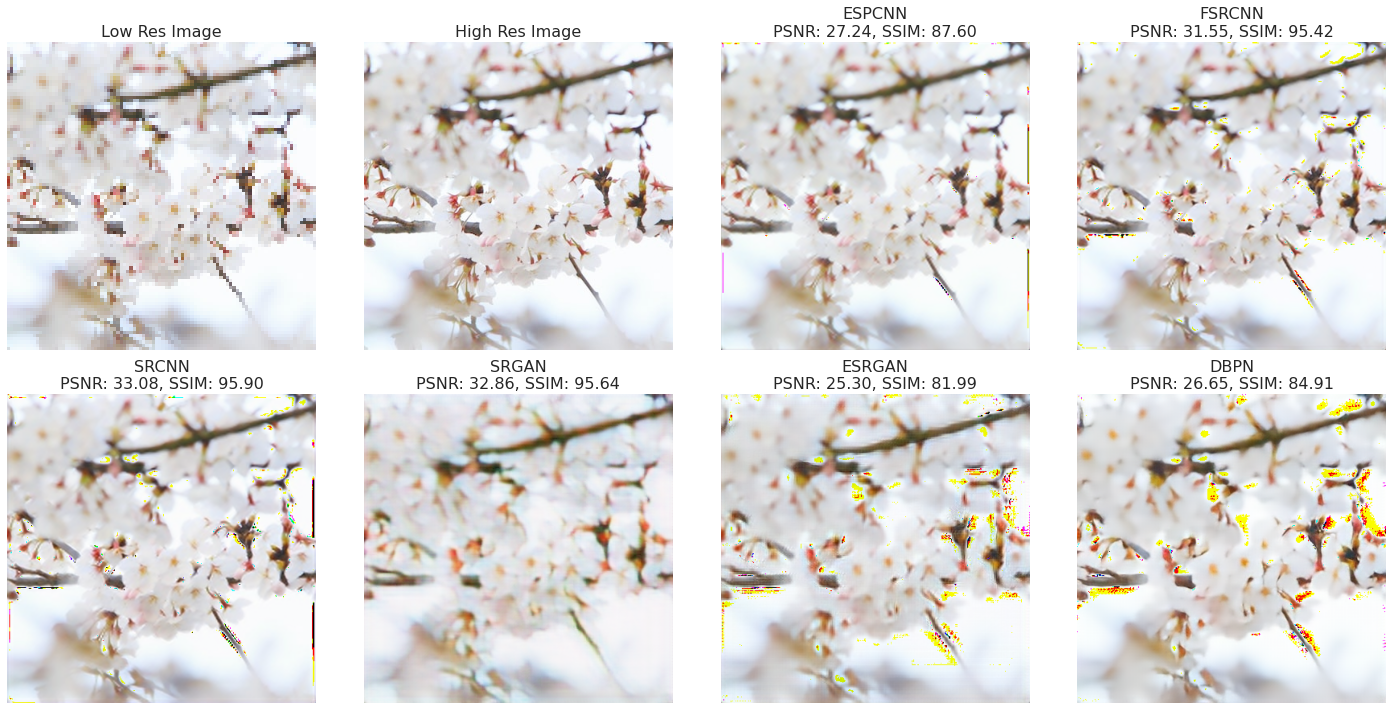

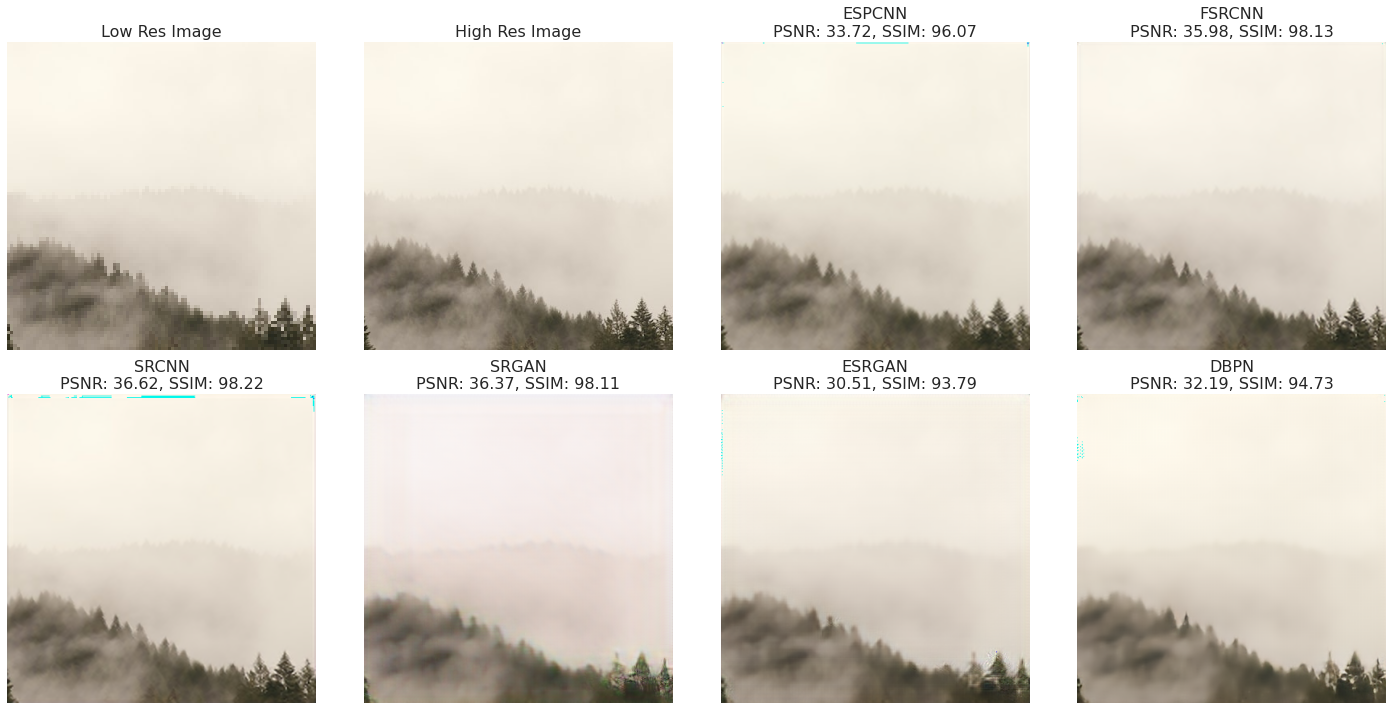

In [55]:
for i in range(num_images):
    display_images_grid(i, low_res_dir, high_res_dir, output_dir, model_names)
